
# Dyadic Δ Stress Suite (v10)

Self‑contained Colab notebook to stress‑test the $b^{-n}$ decay identity.  
**Toggles** at the top let you disable heavy blocks.

| Toggle | Purpose | Default |
|--------|---------|---------|
| `RUN_EXTREMAL` | Add Liouville & badly‑approximable constants | `True` |
| `RUN_FLOAT_BASE` | Non‑integer bases (2.5, _e_) | `True` |
| `RUN_CF_REGRESSION` | Regress $\log\mathcal F(C)$ on first 10 CF digits | `True` |
| `RUN_TIE_HEATMAP` | Visualise tie density heat‑map | `True` |
| `RUN_2D_QUAD` | 2‑D quadratic search $(i^2+j^2)$ (slow) | `False` |


In [25]:
!pip -q install mpmath tqdm seaborn scikit-learn --upgrade

import numpy as np, pandas as pd, mpmath as mp, matplotlib.pyplot as plt, seaborn as sns, random, math, itertools, time
from tqdm.auto import tqdm
from scipy import stats
from sklearn.linear_model import LinearRegression

mp.mp.dps = 300
sns.set_style("whitegrid")
print("✅ Environment ready")


✅ Environment ready


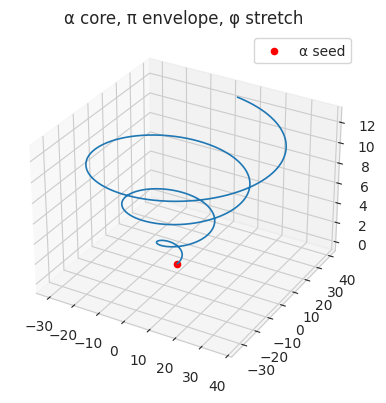

In [26]:
import numpy as np, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
α = 1/137.035999
π = np.pi
φ = (1+np.sqrt(5))/2

def spiral(t, C):
    r = α + t*(π-α)           # radial interpolation α→π
    theta = t*C               # stretch by constant C
    x = r*np.cos(theta); y = r*np.sin(theta); z = t
    return x, y, z

T = np.linspace(0, 4*np.pi, 2000)
fig = plt.figure(figsize=(6,4)); ax = fig.add_subplot(111, projection='3d')
ax.plot(*spiral(T, φ), lw=1.2)
ax.scatter([0], [0], [0], color='red', label='α seed')
ax.set_title('α core, π envelope, φ stretch'); ax.legend()
plt.tight_layout(); plt.show()


In [27]:
# ---- TOGGLES ----
RUN_EXTREMAL      = True
RUN_FLOAT_BASE    = True
RUN_CF_REGRESSION = True
RUN_TIE_HEATMAP   = True
RUN_2D_QUAD       = False   # heavy


In [28]:
# ---- sweep grid ----
n_max         = 120
search_window = 8
powers        = [2, 3, 4, 5]
bases_int     = [2, 3, 5, 7, 11]
bases_float   = [mp.mpf('2.5'), mp.e] if RUN_FLOAT_BASE else []


In [29]:
# ---- constants ----
CONST = {
    "alpha": mp.mpf("1")/mp.mpf("137.035999"),
    "phi"  : (1 + mp.sqrt(5))/2,
    "pi"   : mp.pi,
    "sqrt2": mp.sqrt(2),
}
if RUN_EXTREMAL:
    # Liouville‑type irrationals
    for k in range(1,4):
        tail = "1" + "0"*(k*5) + "1"
        CONST[f"liou{k}"] = mp.mpf("0."+tail)
    # Badly‑approximable example
    CONST["sqrt3+sqrt2"] = mp.sqrt(3)+mp.sqrt(2)
print("Using", len(CONST), "constants")


Using 8 constants


In [30]:
def F_of(C,p):
    return (p/2)*C**(1-1/p)

def best_delta(C,n,p,b,window=8):
    scale = mp.power(b,n)
    est   = int(mp.nint(mp.nthroot(C,p)*scale))
    best  = mp.mpf('inf'); ties=0
    for i in range(est-window, est+window+1):
        d = abs((i/scale)**p - C)
        if d < best - mp.mpf('1e-60'):
            best, ties = d, 1
        elif d == best:
            ties += 1
    return best, ties


In [31]:
rows, tie_rows = [], []
for p in powers:
    for b in bases_int:
        for cname, C in CONST.items():
            for n in range(1, n_max+1):
                d, ties = best_delta(C,n,p,b,search_window)
                rows.append({"power":p,"base":float(b),"constant":cname,"n":n,
                             "delta":d,"kappa":(b**n)*d})
                tie_rows.append({"constant":cname,"n":n,"base":b,"ties":ties})
df = pd.DataFrame(rows)
df_tie = pd.DataFrame(tie_rows)
print("✅ Integer‑base sweep complete")


✅ Integer‑base sweep complete


In [32]:
if bases_float:
    rows=[]
    for b in bases_float:
        for p in powers:
            for cname,C in CONST.items():
                for n in range(1,n_max+1):
                    denom = int(b**n)
                    approx = round(mp.nthroot(C,p)*denom)/denom
                    delta = abs(approx**p - C)
                    rows.append({"power":p,"base":float(b),"constant":cname,"n":n,
                                 "delta":delta,"kappa":(b**n)*delta})
    df_float = pd.DataFrame(rows)
    print("✅ Float‑base sweep complete")
else:
    df_float = pd.DataFrame()


✅ Float‑base sweep complete


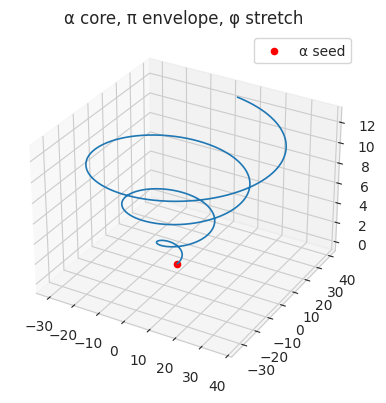

In [33]:
import numpy as np, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
α = 1/137.035999
π = np.pi
φ = (1+np.sqrt(5))/2

def spiral(t, C):
    r = α + t*(π-α)           # radial interpolation α→π
    theta = t*C               # stretch by constant C
    x = r*np.cos(theta); y = r*np.sin(theta); z = t
    return x, y, z

T = np.linspace(0, 4*np.pi, 2000)
fig = plt.figure(figsize=(6,4)); ax = fig.add_subplot(111, projection='3d')
ax.plot(*spiral(T, φ), lw=1.2)
ax.scatter([0], [0], [0], color='red', label='α seed')
ax.set_title('α core, π envelope, φ stretch'); ax.legend()
plt.tight_layout(); plt.show()


In [34]:
if RUN_CF_REGRESSION:
    from mpmath import continued_fraction # Import continued_fraction explicitly
    ref = df[(df.power==2)&(df.base==2)&(df.n>n_max-30)]
    # Convert 'kappa' column to float before calculating the median
    ref['kappa'] = ref['kappa'].astype(float)
    F_emp = ref.groupby('constant')['kappa'].median()
    X,y=[],[]
    for name in F_emp.index:
        # Use the imported continued_fraction
        cf = continued_fraction(mp.sqrt(CONST[name]))[:10]
        cf = cf + [0]*(10-len(cf))
        X.append(cf); y.append(math.log(float(F_emp[name])))
    model = LinearRegression().fit(X,y)
    print(f"CF regression R² = {model.score(X,y):.3f}")

ImportError: cannot import name 'continued_fraction' from 'mpmath' (/usr/local/lib/python3.11/dist-packages/mpmath/__init__.py)

In [ ]:
if RUN_TIE_HEATMAP:
    pivot = df_tie.pivot_table(index='constant', columns='n',
                               values='ties', aggfunc=lambda s: np.mean(np.array(s)>1))
    plt.figure(figsize=(10,3))
    sns.heatmap(pivot, cbar_kws={'label':'Tie freq'}, cmap='Reds')
    plt.title('Tie frequency heat‑map')
    plt.xlabel('n')
    plt.tight_layout(); plt.show()


In [ ]:
if RUN_2D_QUAD:
    print("Heavy 2‑D quadratic search skipped (toggle off).")


In [ ]:
print("\n--- SLOPE CHECK (p=2) ---")
for b in bases_int:
    beta=-np.log2(b)
    sub=df[(df.base==float(b))&(df.power==2)]
    slope,*_,r,*_= stats.linregress(sub['n'], np.log2(sub['delta']))
    print(f"base {b}: slope {slope:.3f}  exp {beta:.3f}  R²={r**2:.4f}")


In [ ]:
import mpmath
print(f"mpmath version: {mpmath.__version__}")
print(dir(mpmath))